In [1]:
"""


Original paper - https://arxiv.org/abs/1611.08024



"""

'\n\n\nOriginal paper - https://arxiv.org/abs/1611.08024\n\n\n\n'

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


# Load in Hospital Data

(3215, 3802)
(3215, 2, 256)
min max of epochs: -1.0 1.0000000000000004
Label Distribution: Counter({1.0: 1740, 0.0: 1475})


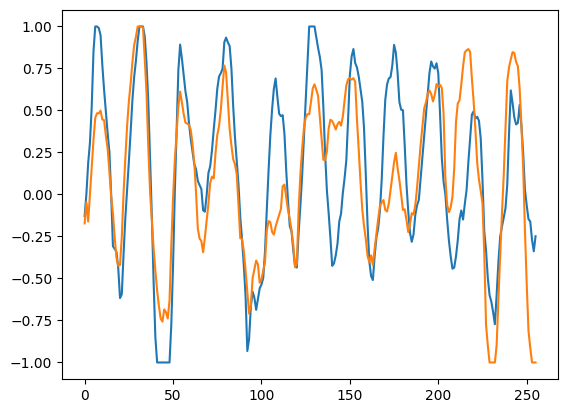

In [7]:
import pickle
from collections import Counter


dir = "E:/ChristianMusaeus/Data/Eyes_closed_marked"
data = pd.read_csv(f"{dir}/df_EOandEC_norm.csv")

print(data.shape)

labels = data.iloc[:, -2].values
patient_ids = data.iloc[:, -1].values
# load f"{dir}/df_EOandEC_norm_hospital_chan8_9.npy"
data = np.load(f"{dir}/df_EOandEC_norm_hospital_ch8_9.npy", allow_pickle=True)


print(data.shape)

epochs = data
print(f"min max of epochs: {np.min(epochs)} {np.max(epochs)}")

import matplotlib.pyplot as plt
plt.plot(epochs[0].reshape(2,256).T)

# Assuming 'labels' is a NumPy array or a Pandas Series
label_counts = Counter(labels)
print("Label Distribution:", label_counts)


# EEGNet 8,2 from paper, for 2 chan hospital


In [8]:
class EEGNetModel(nn.Module):  # EEGNET-8,2
    def __init__(self, chans=2, classes=1, time_points=256, temp_kernel=128,
                 f1=8, f2=16, d=2, pk1=4, pk2=4, dropout_rate=0.1, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()


        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),  # Temporal Conv
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        # Separable Convolution
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16), padding='same', bias=False, groups=f2),  # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False),  # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),  # Pool over time dimension
            nn.Dropout(dropout_rate)
        )
        

        # Fully Connected
        self.fc = nn.Linear(16 * ( time_points // 16 ), classes)

    #     # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        # Input x is (batch_size,1, num_channels, num_timepoints)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        #print(f"pre fc activations: {x.mean()}, {x.std()}")
        x = self.fc(x)
        #print(f"post fc activations: {x.mean()}, {x.std()}")
        x = torch.sigmoid(x)
        return x


# Adjust input size to (19x200)
sample_len = 256  # Your time points
channels = 2     # Your number of channels

# summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# check if CUDA is available
print(device)
torch.cuda.is_available()
torch.cuda.get_device_name(0)

model = EEGNetModel(chans=channels, time_points=sample_len).to(device)
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)
# summary(model, (1, 19, 200))
for param in model.parameters():
    param.requires_grad = True
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter '{name}' does require gradients.")

print(model.forward(torch.rand(13, 1, channels, sample_len).to(device)))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda
Parameter 'block1.0.weight' does require gradients.
Parameter 'block1.1.weight' does require gradients.
Parameter 'block1.1.bias' does require gradients.
Parameter 'block2.0.weight' does require gradients.
Parameter 'block2.1.weight' does require gradients.
Parameter 'block2.1.bias' does require gradients.
Parameter 'block3.0.weight' does require gradients.
Parameter 'block3.1.weight' does require gradients.
Parameter 'block3.2.weight' does require gradients.
Parameter 'block3.2.bias' does require gradients.
Parameter 'fc.weight' does require gradients.
Parameter 'fc.bias' does require gradients.


c:\Users\TMS-EEG\Desktop\.venv\Lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,


tensor([[0.2911],
        [0.4119],
        [0.4537],
        [0.5213],
        [0.2231],
        [0.3516],
        [0.4862],
        [0.3162],
        [0.7485],
        [0.3561],
        [0.3316],
        [0.3956],
        [0.2631]], device='cuda:0', grad_fn=<SigmoidBackward0>)


# Dataset Class

torch.Size([13, 2, 256])
tensor([[[ 0.3931,  0.7064,  0.7363,  ...,  0.0206,  0.2836,  0.1827],
         [ 0.5269,  0.6882,  0.6702,  ...,  0.2333,  0.1866, -0.0037]],

        [[ 0.4182,  0.2758,  0.0694,  ..., -0.1359, -0.0973,  0.0666],
         [ 0.3401,  0.1080,  0.0402,  ..., -0.1380, -0.0325, -0.0236]],

        [[ 0.4225,  0.2363,  0.0839,  ...,  0.2903,  0.2677, -0.0813],
         [ 0.3338,  0.2024, -0.0160,  ...,  0.3567,  0.2922,  0.0429]],

        ...,

        [[ 0.8356,  0.3976,  0.9008,  ...,  0.2284,  0.2366,  0.2204],
         [ 0.5927,  0.8230,  0.3910,  ...,  0.2106,  0.2797,  0.2439]],

        [[-0.1339, -0.1174, -0.3270,  ...,  0.1630,  0.0778, -0.2741],
         [-0.0788, -0.1897, -0.3849,  ...,  0.0764, -0.0435, -0.5116]],

        [[-0.2039, -0.3081, -0.2953,  ..., -0.1324, -0.1156, -0.1349],
         [-0.3055, -0.2790, -0.2591,  ..., -0.1183, -0.0586, -0.1247]]],
       device='cuda:0')


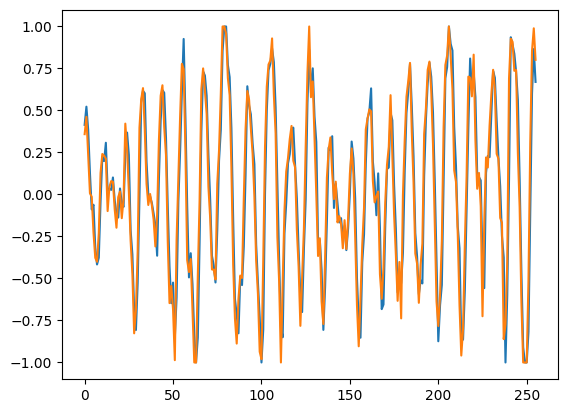

In [9]:
from torch.utils.data import DataLoader, Dataset

# Dataset class definition
class EEGDataset(Dataset):
    def __init__(self, epochs, labels):
        self.df = epochs
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Access the epoch and corresponding label
        data = self.df[idx]  # data shape: (3800)
        data = data.reshape(256,2).T  # shape: (19, 200)
        label = self.labels[idx]  # label shape: (1)
        
        # Ensure the data is converted to float tensor
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
        
        # Convert label to tensor (assumed to be scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).to(device)
        
        return data_tensor, label_tensor

# Create EEGDataset object and print a batch of 13 samples
dataset = EEGDataset(epochs, labels)
dataloader = DataLoader(dataset, batch_size=13, shuffle=True)

print(next(iter(dataloader))[0].shape)
print(next(iter(dataloader))[0])
# plot an epoch from a batch
import matplotlib.pyplot as plt
plt.plot(next(iter(dataloader))[0][0].cpu().numpy().T)


# Training and evaluation loop on hospital 2chan

In [11]:
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
import torch
import numpy as np

# Data is already loaded
print(epochs.shape)

# define random seed
torch.manual_seed(7)

# multiply data with a coefficient
coefs = [10000,1000,100,10, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
epochs_copy = epochs.copy()
# epochs_copy *= coefs[7]

batch_size = 32
num_epochs = 50
patience = 20  # Stop if no improvement after 20 epochs
best_val_acc = 0.0  # Track the best validation accuracy
no_improvement_epochs = 0  # Track how many epochs without improvement

# Lists to store loss values for plotting later
train_loss_history = []
val_loss_history = []

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

model = EEGNetModel().to(device)

# patient_ids = np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], len(epochs) // 10)  # Adjust the length accordingly
# # patient_ids = patient_ids
# labels = np.repeat([0, 1], len(epochs) // 2)  # Adjust the length accordingly
all_preds = []
for epoch in tqdm(range(num_epochs)):  # Loop over the number of epochs
    with torch.enable_grad():
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         print(f"Parameter '{name}' does require gradients.")

        print(f"Epoch {epoch+1}")
        running_loss = []
        running_val_loss = []

        for train_index, test_index in logo.split(epochs_copy, labels, groups=patient_ids):
            
            # Train and test split
            X_train, X_val = epochs_copy[train_index, :], epochs_copy[test_index, :]
            y_train, y_val = labels[train_index], labels[test_index]
            
            # Create DataLoader for training and testing
            train_dataset = EEGDataset(X_train, y_train) # for testing purposes
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = EEGDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            # for batch in train_loader:
            #     print(f" min and max and mean and std of batch: {torch.min(batch[0])} {torch.max(batch[0])} {torch.mean(batch[0])} {torch.std(batch[0])}")
            #     break
            # Training
            model.train()
            for i, data in enumerate(train_loader, 0):
                # Get the inputs; data is a list of [inputs, labels/targets]
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                
                # check if the input shape is correct
                inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed
                # print(f"input shape: {inputs.shape}")

            
                # Forward pass
                outputs = model(inputs)
                targets = targets.unsqueeze(1)  # Ensure targets have the same shape as outputs
                loss = criterion(outputs, targets)
                
                # Backward pass and optimization
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
                # for name, param in model.named_parameters():
                #     if param.requires_grad and param.grad is not None:
                #         print(f"{name}: Grad Mean = {param.grad.mean()}, Grad Std = {param.grad.std()}")
                        # if torch.isnan(param.grad).any():
                        #     print(f"NaN detected in gradients of {name}")
                        
                optimizer.step()
                # for name, param in model.named_parameters():
                #     print(f"mean of data: {torch.mean(param.data)}")
                # Zero the parameter gradients
                optimizer.zero_grad()


                running_loss.append(loss.item())

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        accuracies = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # inputs, targets = Variable(inputs), Variable(targets)
                inputs = inputs.unsqueeze(1)  # Add a channel dimension if needed

                outputs = model(inputs)
                predicted = (outputs < 0.5).float()
                all_preds.append(predicted.cpu().numpy())
                loss = criterion(outputs, targets.unsqueeze(1))
                running_val_loss.append(loss.item())

                # Calculate validation accuracy
                total += targets.size(0)
                correct += (predicted.squeeze() == targets).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        avg_val_loss = np.mean(running_val_loss)
        
        # Print losses and accuracy for current epoch
        print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy} %')
        print(f"Training Loss: {np.mean(running_loss):.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Store losses for plotting later
        train_loss_history.append(np.mean(running_loss))
        val_loss_history.append(avg_val_loss)

        # Early Stopping logic
        if accuracy > best_val_acc:
            best_val_acc = accuracy  # Update the best validation accuracy
            no_improvement_epochs = 0  # Reset the counter if there's improvement
            torch.save(model.state_dict(), f"{dir}/EEGNet_model_2chan_hospital.pth")  # Save the best model
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break  # Exit the training loop


(3215, 2, 256)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 1/50 [00:16<13:27, 16.47s/it]

Epoch 1, Validation Accuracy: 36.04651162790697 %
Training Loss: 0.7265, Validation Loss: 0.6867
Epoch 2


  4%|▍         | 2/50 [00:32<12:55, 16.15s/it]

Epoch 2, Validation Accuracy: 34.883720930232556 %
Training Loss: 0.7262, Validation Loss: 0.6868
Epoch 3


  6%|▌         | 3/50 [00:48<12:29, 15.94s/it]

Epoch 3, Validation Accuracy: 34.883720930232556 %
Training Loss: 0.7260, Validation Loss: 0.6866
Epoch 4


  8%|▊         | 4/50 [01:04<12:16, 16.00s/it]

Epoch 4, Validation Accuracy: 34.883720930232556 %
Training Loss: 0.7267, Validation Loss: 0.6867
Epoch 5


 10%|█         | 5/50 [01:20<12:05, 16.13s/it]

Epoch 5, Validation Accuracy: 34.883720930232556 %
Training Loss: 0.7264, Validation Loss: 0.6866
Epoch 6


 10%|█         | 5/50 [01:22<12:20, 16.47s/it]


KeyboardInterrupt: 

In [40]:
dir = "E:\ChristianMusaeus\Data\Eyes_closed_marked"


# load in scaled_rawEEG_epochs.npy
dir = "E:/ChristianMusaeus/Data/Turkish"
epochs = np.load(f"{dir}/scaled_rawEEG_epochs.npy")
print(epochs.shape)

# define random seed
torch.manual_seed(7)

# multiply data with a coefficient
coefs = [10000,1000,100,10, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
epochs_copy = epochs.copy()
# epochs_copy *= coefs[7]

batch_size = 32
num_epochs = 50
patience = 20  # Stop if no improvement after 20 epochs
best_val_acc = 0.0  # Track the best validation accuracy
no_improvement_epochs = 0  # Track how many epochs without improvement

# Lists to store loss values for plotting later
train_loss_history = []
val_loss_history = []

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

model = EEGNetModel().to(device)

patient_ids = np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], len(epochs) // 10)  # Adjust the length accordingly
# patient_ids = patient_ids
labels = np.repeat([0, 1], len(epochs) // 2)  # Adjust the length accordingly

all_preds = []

for epoch in tqdm(range(num_epochs)):  # Loop over the number of epochs

    with torch.enable_grad():
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         print(f"Parameter '{name}' does require gradients.")

        print(f"Epoch {epoch+1}")
        running_loss = []
        running_val_loss = []

        for train_index, test_index in logo.split(epochs_copy, labels, groups=patient_ids):
            # print(f"test_index: {test_index}")
            # print(f"train_index: {train_index}")
            # Train and test split
            X_train, X_val = epochs_copy[train_index, :], epochs_copy[test_index, :]
            y_train, y_val = labels[train_index], labels[test_index]
            
            # Create DataLoader for training and testing
            train_dataset = EEGDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = EEGDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            # for batch in train_loader:
            #     print(f" min and max and mean and std of batch: {torch.min(batch[0])} {torch.max(batch[0])} {torch.mean(batch[0])} {torch.std(batch[0])}")
            #     break
            # Training
            model.train()

            for i, data in enumerate(train_loader, 0):
                # Get the inputs; data is a list of [inputs, labels/targets]
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                
                # check if the input shape is correct
                inputs = inputs.unsqueeze(1)
                # print(f"input shape: {inputs.shape}")


                # Forward pass
                outputs = model(inputs)
                targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
                # for name, param in model.named_parameters():
                #     if param.requires_grad and param.grad is not None:
                #         print(f"{name}: Grad Mean = {param.grad.mean()}, Grad Std = {param.grad.std()}")
                        # if torch.isnan(param.grad).any():
                        #     print(f"NaN detected in gradients of {name}")

                optimizer.step()
                # for name, param in model.named_parameters():
                #     print(f"mean of data: {torch.mean(param.data)}")
                # Zero the parameter gradients
                optimizer.zero_grad()


                running_loss.append(loss.item())

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        accuracies = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # print(f"targets sum: {torch.sum(targets)}")
                # inputs, targets = Variable(inputs), Variable(targets)
                inputs = inputs.unsqueeze(1)

                outputs = model(inputs)
                predicted = (outputs < 0.5).float()
                all_preds.append(predicted.cpu().numpy())
                loss = criterion(outputs, targets.unsqueeze(1))
                running_val_loss.append(loss.item())

                # Calculate validation accuracy
                total += targets.size(0)
                correct += (predicted.squeeze() == targets).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        avg_val_loss = np.mean(running_val_loss)

        # Print losses and accuracy for current epoch

        print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy} %')
        print(f"Training Loss: {np.mean(running_loss):.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Store losses for plotting later
        train_loss_history.append(np.mean(running_loss))
        val_loss_history.append(avg_val_loss)

        # Early Stopping logic
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            no_improvement_epochs = 0
            torch.save(model.state_dict(), f"{dir}/EEGNet_model.pth")
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        

(2980, 256, 19)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 1/50 [00:05<04:44,  5.80s/it]

Epoch 1, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.6999, Validation Loss: 0.7045
Epoch 2


  4%|▍         | 2/50 [00:11<04:31,  5.66s/it]

Epoch 2, Validation Accuracy: 96.97986577181209 %
Training Loss: 0.6999, Validation Loss: 0.7039
Epoch 3


  6%|▌         | 3/50 [00:17<04:25,  5.66s/it]

Epoch 3, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.6995, Validation Loss: 0.7044
Epoch 4


  8%|▊         | 4/50 [00:22<04:18,  5.63s/it]

Epoch 4, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.7001, Validation Loss: 0.7045
Epoch 5


 10%|█         | 5/50 [00:28<04:09,  5.55s/it]

Epoch 5, Validation Accuracy: 97.6510067114094 %
Training Loss: 0.6997, Validation Loss: 0.7044
Epoch 6


 12%|█▏        | 6/50 [00:33<04:05,  5.58s/it]

Epoch 6, Validation Accuracy: 98.32214765100672 %
Training Loss: 0.6996, Validation Loss: 0.7049
Epoch 7


 14%|█▍        | 7/50 [00:39<04:00,  5.60s/it]

Epoch 7, Validation Accuracy: 98.32214765100672 %
Training Loss: 0.6997, Validation Loss: 0.7053
Epoch 8


 16%|█▌        | 8/50 [00:44<03:52,  5.55s/it]

Epoch 8, Validation Accuracy: 94.96644295302013 %
Training Loss: 0.7004, Validation Loss: 0.7029
Epoch 9


 18%|█▊        | 9/50 [00:50<03:45,  5.50s/it]

Epoch 9, Validation Accuracy: 98.32214765100672 %
Training Loss: 0.6999, Validation Loss: 0.7047
Epoch 10


 20%|██        | 10/50 [00:55<03:38,  5.47s/it]

Epoch 10, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.7002, Validation Loss: 0.7045
Epoch 11


 22%|██▏       | 11/50 [01:01<03:33,  5.47s/it]

Epoch 11, Validation Accuracy: 97.6510067114094 %
Training Loss: 0.6999, Validation Loss: 0.7044
Epoch 12


 24%|██▍       | 12/50 [01:06<03:26,  5.44s/it]

Epoch 12, Validation Accuracy: 96.97986577181209 %
Training Loss: 0.7005, Validation Loss: 0.7039
Epoch 13


 26%|██▌       | 13/50 [01:11<03:22,  5.48s/it]

Epoch 13, Validation Accuracy: 97.31543624161074 %
Training Loss: 0.7003, Validation Loss: 0.7043
Epoch 14


 28%|██▊       | 14/50 [01:17<03:18,  5.51s/it]

Epoch 14, Validation Accuracy: 97.31543624161074 %
Training Loss: 0.7006, Validation Loss: 0.7042
Epoch 15


 30%|███       | 15/50 [01:22<03:12,  5.50s/it]

Epoch 15, Validation Accuracy: 97.6510067114094 %
Training Loss: 0.6991, Validation Loss: 0.7044
Epoch 16


 32%|███▏      | 16/50 [01:28<03:04,  5.42s/it]

Epoch 16, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.6996, Validation Loss: 0.7047
Epoch 17


 34%|███▍      | 17/50 [01:33<02:58,  5.39s/it]

Epoch 17, Validation Accuracy: 98.32214765100672 %
Training Loss: 0.6998, Validation Loss: 0.7049
Epoch 18


 36%|███▌      | 18/50 [01:38<02:51,  5.35s/it]

Epoch 18, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.6991, Validation Loss: 0.7046
Epoch 19


 38%|███▊      | 19/50 [01:44<02:48,  5.44s/it]

Epoch 19, Validation Accuracy: 96.64429530201342 %
Training Loss: 0.6997, Validation Loss: 0.7038
Epoch 20


 40%|████      | 20/50 [01:50<02:44,  5.49s/it]

Epoch 20, Validation Accuracy: 96.64429530201342 %
Training Loss: 0.7002, Validation Loss: 0.7038
Epoch 21


 42%|████▏     | 21/50 [01:55<02:39,  5.51s/it]

Epoch 21, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.7000, Validation Loss: 0.7044
Epoch 22


 44%|████▍     | 22/50 [02:00<02:31,  5.42s/it]

Epoch 22, Validation Accuracy: 97.98657718120805 %
Training Loss: 0.6994, Validation Loss: 0.7045
Epoch 23


 46%|████▌     | 23/50 [02:06<02:24,  5.35s/it]

Epoch 23, Validation Accuracy: 97.31543624161074 %
Training Loss: 0.6996, Validation Loss: 0.7041
Epoch 24


 48%|████▊     | 24/50 [02:11<02:17,  5.29s/it]

Epoch 24, Validation Accuracy: 97.31543624161074 %
Training Loss: 0.6998, Validation Loss: 0.7041
Epoch 25


 50%|█████     | 25/50 [02:16<02:11,  5.25s/it]

Epoch 25, Validation Accuracy: 96.64429530201342 %
Training Loss: 0.7003, Validation Loss: 0.7039
Epoch 26


 50%|█████     | 25/50 [02:21<02:21,  5.66s/it]

Epoch 26, Validation Accuracy: 95.63758389261746 %
Training Loss: 0.6997, Validation Loss: 0.7033
Early stopping at epoch 26


In [32]:
all_preds = np.concatenate(all_preds)
print(all_preds.shape)
print(np.sum(all_preds))

(5364, 1)
126.0


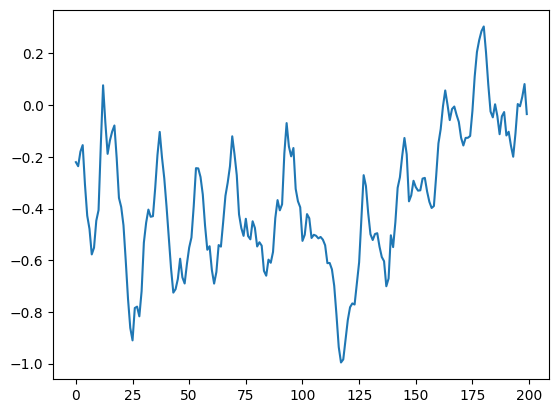

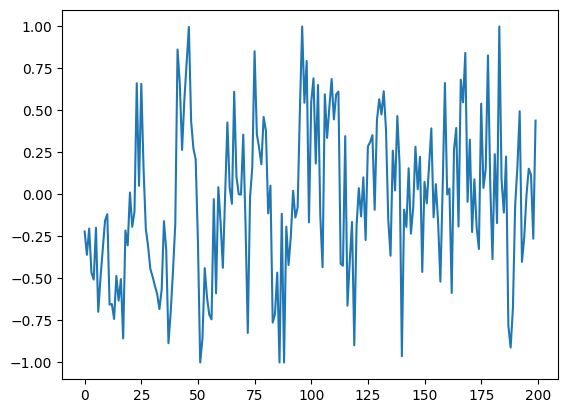

In [ ]:
import matplotlib.pyplot as plt
plotdata = epochs[0, :].reshape(19, 200)


plt.plot(plotdata[0,:])
plt.show()
plotdata2 = epochs[0, :].reshape(200, 19)
plt.plot(plotdata2[:,0])
plt.show()

# Dont look under here

In [ ]:
from sklearn.model_selection import train_test_split

# Split data once before training
X_train, X_val, y_train, y_val = train_test_split(
    epochs, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in tqdm(range(num_epochs)):  # Loop over the number of epochs
    print(f"Epoch {epoch+1}")
    running_loss = []
    running_val_loss = []

    # Training Phase
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Add channel dimension if needed

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Monitor gradients
        for name, param in model.named_parameters():
            # if param.requires_grad and param.grad is not None:
            #     grad_mean = param.grad.mean().item()
            #     grad_std = param.grad.std().item()
            #     print(f"{name}: Grad Mean = {grad_mean}, Grad Std = {grad_std}")
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradients of {name}")
                # chewck if the gradients are positive
                if (param.grad > 0).any():
                    print(f"Positive gradients detected in {name}")

        optimizer.step()

        running_loss.append(loss.item())

    # Validation Phase
    model.eval()
    correct = 0
    total = 0
    running_val_loss = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension if needed

            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()
            
            loss = criterion(outputs, targets.unsqueeze(1))
            running_val_loss.append(loss.item())

            correct += (predicted.squeeze() == targets).sum().item()
            total += targets.size(0)

    accuracy = 100 * correct / total
    avg_train_loss = np.mean(running_loss)
    avg_val_loss = np.mean(running_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%')

    # Early Stopping
    if accuracy > best_val_acc:
        best_val_acc = accuracy
        no_improvement_epochs = 0
        torch.save(model.state_dict(), f"{dir}/EEGNet_model.pth")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f" no improvement :{no_improvement_epochs}")
        print(f"Early stopping at epoch {epoch+1}")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
Positive gradients detected in block1.0.weight
Positive gradients detected in block1.1.weight
Positive gradients detected in block1.1.bias
Positive gradients detected in block2.0.weight
Positive gradients detected in block2.1.weight
Positive gradients detected in block2.1.bias
Positive gradients detected in block3.0.weight
Positive gradients detected in block3.1.weight
Positive gradients detected in block3.2.weight
Positive gradients detected in block3.2.bias
Positive gradients detected in fc.weight
Positive gradients detected in block1.0.weight
Positive gradients detected in block1.1.weight
Positive gradients detected in block1.1.bias
Positive gradients detected in block2.0.weight
Positive gradients detected in block2.1.weight
Positive gradients detected in block2.1.bias
Positive gradients detected in block3.0.weight
Positive gradients detected in block3.1.weight
Positive gradients detected in block3.2.weight
Positive gradients detected in block3.2.bias
Positive gradients dete

  0%|          | 0/50 [00:01<?, ?it/s]

Epoch 1, Train Loss: 0.6912, Val Loss: 0.6750, Val Acc: 54.12%
 no improvement :21
Early stopping at epoch 1


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Please check your installation.")

    import numpy as np

print(f"Any NaNs in data: {np.isnan(epochs).any()}")
print(f"Any Infs in data: {np.isinf(epochs).any()}")

Using device: cuda
CUDA Version: 11.8
CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
Any NaNs in data: False
Any Infs in data: False


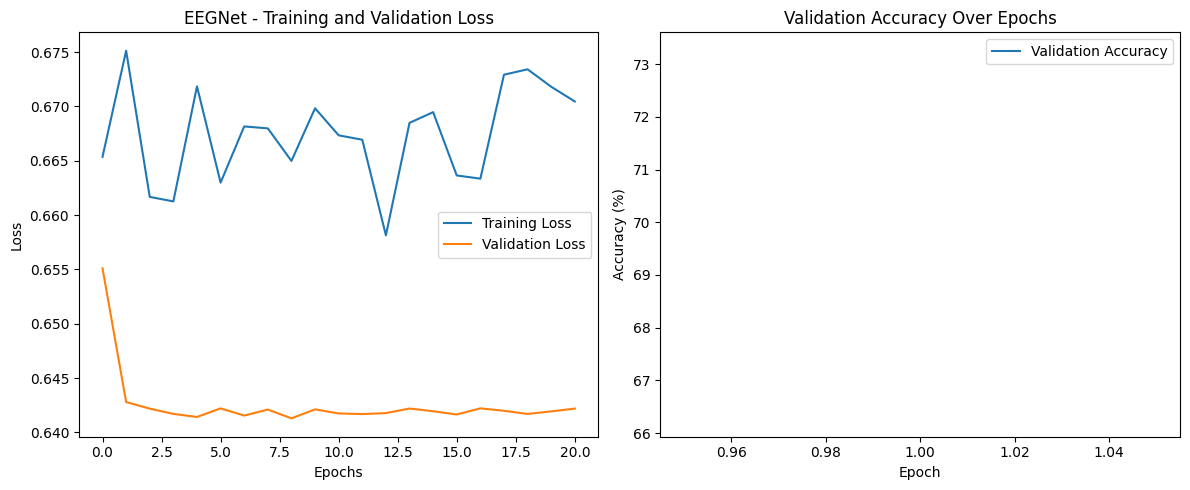

In [ ]:
# PLOTTING
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('EEGNet - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies)+1), accuracies, label='Validation Accuracy')  # Adjust accordingly
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Load Turkish data

In [ ]:
# load the dataframe from the pickle file
import pickle
dir = "E:/ChristianMusaeus/Data/Turkish"
with open(f"{dir}/dataframe.pkl", "rb") as f:
    df = pickle.load(f)

# keep these channels only, these are the indexes: 
""" 
Fp1 -> 0
Fp2 -> 33
F3  -> 4
F4  -> 38
C3  -> 12
C4  -> 48
P3  -> 20
P4  -> 55
O1  -> 26
O2  -> 61
F7  -> 6
F8  -> 40
T7  -> 14
T8  -> 50
P7  -> 22
P8  -> 57
Fz  -> 36
Cz  -> 46
Pz  -> 30 

but add 1 to each index, since the first channel is channel_1
"""

df = df[["channel_1", "channel_34", "channel_5", "channel_39", "channel_13", "channel_49", "channel_21", "channel_56", "channel_27", "channel_62", "channel_7", "channel_41", "channel_15", "channel_51", "channel_23", "channel_58", "channel_37", "channel_47", "channel_31", "label"]]

patient_ids = np.repeat([1,2,3,4,5,6,7,8,9,10],76288)  # Make sure to have this aligned with your epochs/labels

# Normalize per patient (within training and test sets)
data = df.drop("label", axis=1).values
data_norm = []
for patient_id in np.unique(patient_ids):
    patient_data = data[patient_ids == patient_id]
    scaler = StandardScaler()
    patient_data_scaled = scaler.fit_transform(patient_data)
    print(f"min and max of patient {patient_id}: {np.min(patient_data_scaled), np.max(patient_data_scaled)}")
    data_norm.append(patient_data_scaled)

data_norm = np.concatenate(data_norm, axis=0)
# add labels back
y = df["label"].values
data = data_norm

# make data a dataframe again
df = pd.DataFrame(data)
print(f"size of df: {df.shape}")

# split the data into epochs of 256 datapoints each
epochs = []
for i in range(0, len(df), 256):
    epochs.append(df.iloc[i:i+256].values)

# convert the list of epochs to a numpy array
epochs = np.array(epochs)
print(f"size of epochs: {epochs.shape}")

# save the SCALED epochs
with open(f"{dir}/scaled_rawEEG_epochs.pkl", "wb") as f:
    pickle.dump(epochs, f)




ModuleNotFoundError: No module named 'numpy._core'

In [ ]:
# open the scaled epochs
import pickle
import pandas as pd
import torch
dir = "E:/ChristianMusaeus/Data/Turkish"

with open(f"{dir}/scaled_rawEEG_epochs.pkl", "rb") as f:
    epochs = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# convert the numpy array to a tensor and move it to the GPU
epochs = torch.tensor(epochs, dtype=torch.float32).to(device)
print()
# print(torch.rand(2,3).cuda())



device: cuda



In [ ]:
labels = []
for _ in range(10):
    labels.append(np.repeat([1, 0], 149))
labels = np.concatenate(labels)

print(f"size of labels: {labels.shape}")


size of labels: (2980,)
